
Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# Gradient Attribution


In [1]:
#@title Import libraries
import transformer_lens
import torch, gc, itertools
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import sys
sys.path.append('/home/jupyter/')
from paraMem.utils import modelHandlers, dataLoaders, gradient, localizing

## Model

In [2]:
model = modelHandlers.load_model(model_type="gpt-neo-125M", DEVICE="cpu")
modelHandlers.set_no_grad(model, ["embed", "pos_embed", "unembed"])

Loaded pretrained model gpt-neo-125M into HookedTransformer
set no_grad on ['embed', 'pos_embed', 'unembed']
set no_grad on ['embed', 'pos_embed', 'unembed']
set no_grad on ['embed', 'pos_embed', 'unembed']
set no_grad on ['embed', 'pos_embed', 'unembed']


## Load Data

In [5]:
train_dl, test_dl = dataLoaders.batched_pile(mem_batch=10, non_mem_batch=10)
#dl = dataLoaders.batched_pop_seqs(model, mem_batch=1, non_mem_batch=50)
c_toks_NI, k_toks_NI = next(train_dl)

## Gradient Attribution

In [6]:
def pool_tensor(orig_tensor:torch.tensor, dims:list):
    if dims is not None:
        for dim in dims:
            orig_tensor_pooled = orig_tensor.mean(dim)
            orig_tensor = torch.repeat_interleave(orig_tensor_pooled.unsqueeze(dim), orig_tensor.shape[dim], dim=dim)
    return orig_tensor


def contrast_metric(c_nll:torch.tensor, k_nll:torch.tensor, with_mse:bool=True, after_I:int=0, norm_sets:bool=True, pool:dict={"c": None, "k": None}):
    """
    minimizing / preserve keep_score while maximizing change_score
    """
    ## (1) preprocess________________________________________
    ## select latter tokens to apply metric to
    c_nll, k_nll = c_nll[...,after_I:], k_nll[...,after_I:]
        
    if norm_sets: ## balance out loss terms  
        c_nll = torch.nn.functional.normalize(c_nll, p=2.0, dim=-1)
        k_nll = torch.nn.functional.normalize(k_nll, p=2.0, dim=-1)
        
    ## (2) pooling_______________________________________________
    ## pool over dims but then expand again to retain shapes
    k_nll = pool_tensor(k_nll, pool["k"])
    c_nll = pool_tensor(c_nll, pool["c"])
            
    ## adjust shapes
    ## clip batch sizes and paragraph lengths always to shorter version
    c_nll = c_nll[:k_nll.shape[0], :k_nll.shape[1]]
    k_nll = k_nll[:c_nll.shape[0], :c_nll.shape[1]]

    ## (3) apply actual metric_______________________________________________
    if with_mse: ## mean squared error version to enforce non-changing keep set NLL
        k_nll = (k_nll-k_nll.detach())**2
    contrast_res = (c_nll - k_nll).mean()

    ## (4) postprocess_______________________________________________
    ## normalizing score over tokens
    rightLeft_type="metric"
    if rightLeft_type=="metric":
        rightLeft_norm = torch.cumsum(torch.abs(contrast_res).flip(dims=(0,)), dim=0).flip(dims=(0,))  
    elif rightLeft_type=="tokens":
        rightLeft_norm = torch.arange(1,contrast_res.shape[0]+1).flip(dims=(0,))
    else:
        rightLeft_norm = None

    print(f"contrast_res: {contrast_res}, c_nll: {c_nll.detach().mean()}, k_nll: {k_nll.detach().mean()}")
    return contrast_res, rightLeft_norm


In [8]:
def run_fwd_bwd(model,c_toks_NI:torch.LongTensor,k_toks_NI:torch.LongTensor=None,after_I:int=0,with_mse:bool=True,pool:dict={"c":[-1],"k":[0,-1]}, norm_sets:bool=False):
    """
    adding hooks to model, running model on data on metric and returning cached activs, params are cached in model
    """
    fwd_cache, bwd_cache = gradient.add_fwd_bwd_hooks(model, hook_filter={"not in":"_input"})
    if k_toks_NI is not None: 
        c_nll = modelHandlers.gather_token_scores(modelHandlers.NegLogLik(model(c_toks_NI.to(model.cfg.device))).to("cpu"), c_toks_NI)
        k_nll = modelHandlers.gather_token_scores(modelHandlers.NegLogLik(model(k_toks_NI.to(model.cfg.device))).to("cpu"), k_toks_NI)
        metric_res, metric_norm = contrast_metric(c_nll, k_nll, with_mse=with_mse, after_I=after_I, norm_sets=False, pool=pool)
    elif k_toks_NI is None: ## --> single_seq version
        nll_NIT = modelHandlers.NegLogLik(model(c_toks_NI.to(model.cfg.device)))
        toks_nll_NI = modelHandlers.gather_token_scores(nll_NIT, c_toks_NI)
        top_nll_NIk,_ = modelHandlers.get_topK(nll_NIT, topK=100, minK=True)
        top_nll_kI = top_nll_NIk.squeeze().transpose(0,1)[...,:-1]
        metric_res, metric_norm = contrast_metric(top_nll_kI[:1,:], top_nll_kI[1:,:], with_mse, after_I=after_I, norm_sets=norm_sets, pool=pool)

    metric_res.backward(retain_graph=False)
    model.reset_hooks()
    fwd_cache = transformer_lens.ActivationCache(fwd_cache, model)
    bwd_cache = transformer_lens.ActivationCache(bwd_cache, model)
    return fwd_cache, bwd_cache

fwd_cache, bwd_cache = run_fwd_bwd(model,c_toks_NI,k_toks_NI,after_I=0,with_mse=True,pool={"c":[-1],"k":[0,-1]}, norm_sets=False)

contrast_res: 0.5131751894950867, c_nll: 0.5131751894950867, k_nll: 0.0


## Analyze Weight Gradients

In [23]:
names, grads = localizing.collect_all_grads(model, pool=[(-1, "max")], norm_n_params=False, keep=".", remove="b_")

 no grad for embed.W_E
 no grad for pos_embed.W_pos
 no grad for unembed.W_U
returning 75: [['embed', 'W_E'], ['pos_embed', 'W_pos'], ['blocks', '0', 'attn', 'W_Q'], ['blocks', '0', 'attn', 'W_K'], ['blocks', '0', 'attn', 'W_V']]...


Text(0, 0.5, 'all max, then mean')

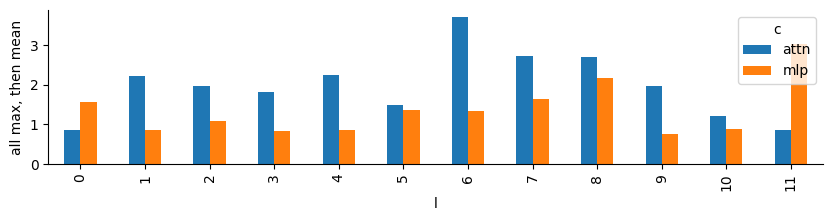

In [24]:
df = pd.DataFrame(list(zip(names,grads)), columns=['names','vals'])
df = pd.concat((df["names"].apply(pd.Series), df["vals"]), axis=1)

## group by layer and module type________________________________
df = df.drop(columns=[0,3], inplace=False)

df = df.rename(columns = {1:"l", 2:"c"})
lc_df = df.groupby(["l","c"]).agg({'vals': "max"}).reset_index()
lc_df["l"] = lc_df["l"].astype(int)
lc_df = lc_df.sort_values(by=["l", "c"], ascending=True) ## sort by layers and c_types
lc_df = lc_df.pivot_table(index='l', columns='c', values='vals')

ax = lc_df.plot(kind='bar',figsize=(10, 2))
ax.set_ylabel("all max, then mean")

Text(0, 0.5, 'all max, then mean')

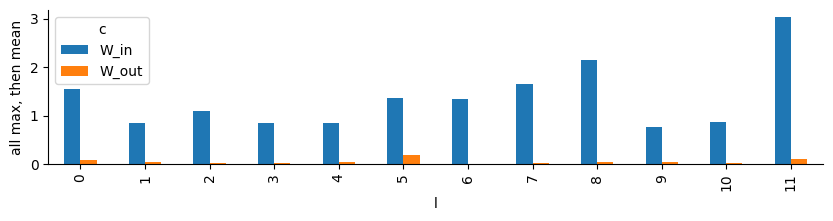

In [25]:
df = pd.DataFrame(list(zip(names,grads)), columns=['names','vals'])
df = pd.concat((df["names"].apply(pd.Series), df["vals"]), axis=1)

## group by layer and module type________________________________
df = df.drop(columns=[0,2], inplace=False) 

df = df.rename(columns = {1:"l", 3:"c"})
lc_df = df.groupby(["l","c"]).agg({'vals': "max"}).reset_index()
lc_df["l"] = lc_df["l"].astype(int)
lc_df = lc_df.sort_values(by=["l", "c"], ascending=True) ## sort by layers and c_types

lc_df = lc_df[lc_df["c"].isin(["W_in", "W_out"])] ## filter for specifc mlp components

lc_df = lc_df.pivot_table(index='l', columns='c', values='vals')

ax = lc_df.plot(kind='bar',figsize=(10, 2))
ax.set_ylabel("all max, then mean")

## Analyse Activation Gradients

In [26]:
#vals, c_names = collect_c_type(model=model, cache=None, c_type="W_in")
vals, c_names = localizing.collect_c_type(model=model, cache=bwd_cache, c_type="mlp_out")
print(vals.shape)
vals =vals.mean(0)
vals = torch.max(vals,dim=-1)[0]
#vals = torch.max(torch.max(vals,dim=-1)[0], dim=-1)[0]
#vals =vals.mean(0).mean(-1) ## "mlp_out"
#vals = torch.abs(vals).mean(-1) ## "mlp_out"
#vals = torch.abs(vals).mean(-1).mean(-1) ## "k", "q", "v"
#vals, _ = torch.max(torch.abs(vals).mean(-1), dim=-1) ## "k", "q", "v"

#vals = vals.mean(-1)[...,10] ## "k", "q", "v"
print(vals.shape)

## normalization
#vals_norm = torch.einsum("LI,I->LI", vals[:,:-1], (1+(1/metric_norm))).detach().numpy()
vals_norm = vals
print(f"{c_names}\n{vals_norm.shape}")

returning ['blocks.0.hook_mlp_out', 'blocks.1.hook_mlp_out']... of shape: torch.Size([1, 12, 100, 768])
torch.Size([1, 12, 100, 768])
torch.Size([12, 100])
['blocks.0.hook_mlp_out', 'blocks.1.hook_mlp_out', 'blocks.2.hook_mlp_out', 'blocks.3.hook_mlp_out', 'blocks.4.hook_mlp_out', 'blocks.5.hook_mlp_out', 'blocks.6.hook_mlp_out', 'blocks.7.hook_mlp_out', 'blocks.8.hook_mlp_out', 'blocks.9.hook_mlp_out', 'blocks.10.hook_mlp_out', 'blocks.11.hook_mlp_out']
torch.Size([12, 100])


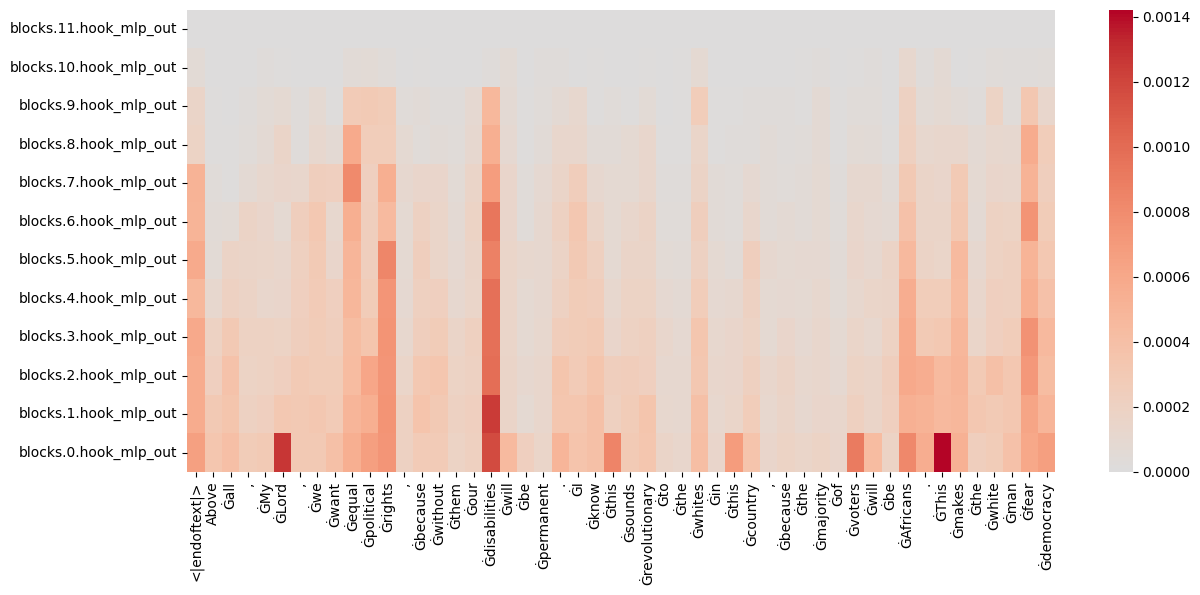

In [27]:
def plot_heatmap(vals:list, x_labels:list=None, y_labels:list=None):
    fig, ax = plt.subplots(1, 1, figsize=(14, 6), gridspec_kw={'hspace': 0.4})
    ax = sns.heatmap(vals,
                  cmap=mpl.colormaps["coolwarm"], center=0,
                  xticklabels=x_labels,
                  yticklabels=y_labels, square=False)
    ax.invert_yaxis()

plot_heatmap(vals_norm[...,:50], x_labels=model.tokenizer.convert_ids_to_tokens(c_toks_NI[0,...,:50]),y_labels=c_names)
#plot_heatmap(vals_norm[...,:], x_labels=model.tokenizer.convert_ids_to_tokens(c_toks_NI[0,...,:]),y_labels=c_names)